## Libreries

In [1]:
import pandas as pd
import numpy as np
import pickle

## Data

In [6]:
%%time
file_path = "D:/github/coherence-prediction/data/df_A2019.xlsx"
df = pd.read_excel(file_path)
columns = "respuesta_id pregunta_id pregunta respuesta tipo_preg C1 C1_iid".split()
df = df[columns]
df

Wall time: 3.48 s


,respuesta_id,pregunta_id,pregunta,respuesta,tipo_preg,C1,C1_iid
0,127991,6976,Redacta un problema de ADICIÓN. El problema de...,amaru tine 15 autos y mi primo me regalo 15 ma...,5,0,0
1,128001,6976,Redacta un problema de ADICIÓN. El problema de...,Andrea quiene 100 \nfloles y su mama reran 2...,5,0,0
2,127987,6976,Redacta un problema de ADICIÓN. El problema de...,juan tiene 5 autos y su amigo le regalo 4 ¿c...,5,0,0
3,127979,6976,Redacta un problema de ADICIÓN. El problema de...,un perro85848548\n,5,1,0
4,127990,6976,Redacta un problema de ADICIÓN. El problema de...,David tenia trenta chocolate y su mama le dio...,5,0,0
...,...,...,...,...,...,...,...
14452,153230,9351,Tres granjas compiten para ver quién produjo m...,quien produjo mas alimento fue la granja b por...,4,0,0
14453,153231,9351,Tres granjas compiten para ver quién produjo m...,la granja que produjo mas alimento es la B,4,0,0
14454,153232,9351,Tres granjas compiten para ver quién produjo m...,la granja que ai mas alimentos esla granja b...,4,0,0
14455,153233,9351,Tres granjas compiten para ver quién produjo m...,lab produjo mas alimento porque tenia de alim...,4,1,0


In [9]:
df.groupby("tipo_preg").apply(lambda x: (x.shape[0]-x["C1"].sum())/x.shape[0])

tipo_preg
0    0.878587
1    0.952037
2    0.845179
3    0.838463
4    0.849817
5    0.914414
dtype: float64

## Split

* 80/20 train/val 
* stratified by question and question type

https://numpy.org/doc/stable/reference/random/generated/numpy.random.RandomState.choice.html

In [287]:
random_seed = 2022

In [288]:
ratio_train = 80/100
ratio_train

0.8

### Stratified by question type

In [289]:
Q = df["pregunta_id tipo_preg".split()]
Q = Q.drop_duplicates(keep="last")

Q_ids = Q["pregunta_id"]
Q_labels = Q["tipo_preg"]
Q_labels_count = Q_labels.value_counts().to_dict()

Q_ids_train = np.array([
    np.random.RandomState(random_seed).choice(
        Q_ids[Q_labels == Q], int( ratio_train * N ), 
        replace=False)
    for Q, N in Q_labels_count.items()
], 
    dtype=object
)

Q_ids_train = np.concatenate(Q_ids_train)
Q_ids_val = np.array(
    list(set(Q_ids).difference(set(Q_ids_train)))
)

<AxesSubplot:>

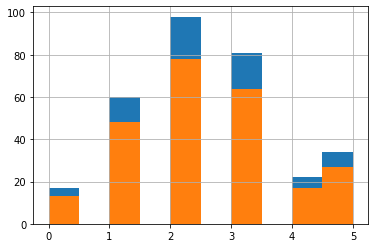

In [291]:
Q_labels.hist(), 
Q[Q["pregunta_id"].isin(Q_ids_train)]["tipo_preg"].hist()

In [292]:
A = df["pregunta_id respuesta_id tipo_preg C1".split()]

A_q_ids = A["pregunta_id"] 
A_q_label = A["tipo_preg"]

A_ids = {
    q: A["respuesta_id"][A_q_label == q]
    for q in Q_labels_count.keys()
}

A_labels = {
    q: A["C1"].loc[A_ids[q].index]
    for q in Q_labels_count.keys()
}

A_labels_count = {
    q: A_labels[q].value_counts().to_dict()
    for q in Q_labels_count.keys()
}

A_ids_train = {
    q: np.array([ 
        np.random.RandomState(random_seed).choice(A_ids[q][A_labels[q] == C], int( ratio_train * N ),
                    replace=False)
        for C, N in A_labels_count[q].items()
    ], 
        dtype=object
    )
    for q in Q_labels_count.keys()
}

A_ids_train = {
    q: np.concatenate(A_ids_train[q])
    for q in Q_labels_count.keys()
}

A_ids_val = {
    q: np.array(
        list(set(A_ids[q]).difference(set(A_ids_train[q])))
    )
    for q in Q_labels_count.keys()
}

In [293]:
def plot_train_val(q):
    return A_labels[q].hist(), A[A["respuesta_id"].isin(A_ids_train[q])]["C1"].hist()

(<AxesSubplot:>, <AxesSubplot:>)

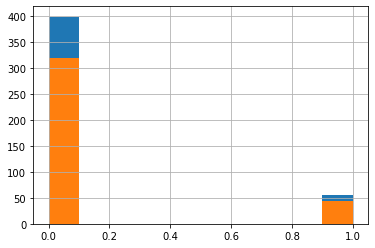

In [294]:
plot_train_val(q=0)

(<AxesSubplot:>, <AxesSubplot:>)

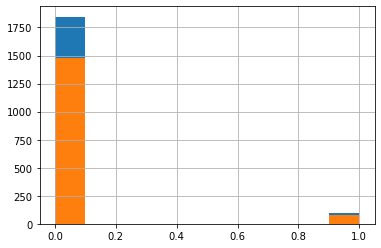

In [295]:
plot_train_val(q=1)

(<AxesSubplot:>, <AxesSubplot:>)

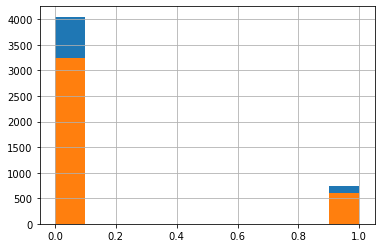

In [296]:
plot_train_val(q=2)

(<AxesSubplot:>, <AxesSubplot:>)

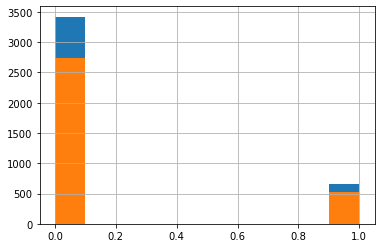

In [297]:
plot_train_val(q=3)

(<AxesSubplot:>, <AxesSubplot:>)

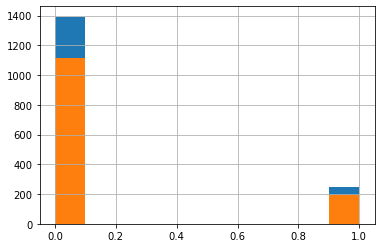

In [298]:
plot_train_val(q=4)

(<AxesSubplot:>, <AxesSubplot:>)

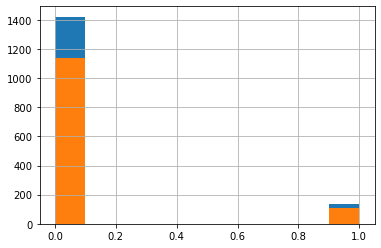

In [299]:
plot_train_val(q=5)

## Save split

In [300]:
pickle.dump(
    {
        "train": Q_ids_train, 
        "val": Q_ids_val
    },
    open("../pickles/Q_ids.pickle", "wb")
)

In [301]:
pickle.dump(
    {
        "train": A_ids_train, 
        "val": A_ids_val
    },
    open("../pickles/A_ids.pickle", "wb")
)